# 基于卷积神经网络的脑电运动成像信号分类
## 数据集
数据来自8个健康的受试者（训练受试者S1～S4，测试受试者S5～S8），每一个受试者执行两类运动想象任务：右手和双脚，脑电信号由一个13通道的脑电帽以512Hz的频率记录得到。我们提供了经过预处理后的数据：下采样到了250Hz，带通滤波至8-32Hz，划分每一次视觉提示出现后的0.5~3.5s之间的EEG信号作为一个trial。每个用户包含200个trial（右手和双脚各100个trial）。
数据以.npz和.mat格式提供，包含：
* X: 预处理后的EEG信号, 维度: [trails * 通道* 采样点]。
* y: 类别标签向量。测试数据不包含此变量。

# MI-EEG signal Classification based on CNN
## Dataset
The dataset were collected from 8 healthy subjects (training subjects S1-S4, test subjects S5-S8), each subject performed two types of motor imagery tasks: right hand and feet, EEG signals were generated by a 13-channel EEG cap recorded at 512 Hz. We provide the preprocessed data: down-sampling to 250Hz, band-pass filtering to 8-32Hz, and dividing the EEG signal between 0.5 and 3.5s after each visual cue appears as a trial. Each user contains 200 trials (100 trials each for the right hand and both feet).
Data is provided in .npz and .mat formats and contains:
* X: Preprocessed EEG signal, dimension: [trails * channels * samples].
* y: category label vector. The test data does not contain this variable.

## 1. Read in Dataset
Read S1-S4 separately, and combine X and Y vectors in the dataset to obtain 800 pieces of data and corresponding labels, then reshape the y vector.
Combined dataset size
* data_X: [800, 13, 750]
* data_y: [800, 1]

In [1]:
# Read in Train Data S1~S4
import numpy as np

datafile1 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S1.npz"
datafile2 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S2.npz"
datafile3 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S3.npz"
datafile4 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S4.npz"

dataSet1 = np.load(datafile1)
dataSet2 = np.load(datafile2)
dataSet3 = np.load(datafile3)
dataSet4 = np.load(datafile4)

In [2]:
# Concatenate Datasets X

data_X = np.concatenate([dataSet1['X'], dataSet2['X']], axis = 0)

data_X = np.concatenate([data_X, dataSet3['X']], axis = 0)

data_X = np.concatenate([data_X, dataSet4['X']], axis = 0)

print('====== Dataset Train S1~S4 -> X ======')
print('Type:', type(data_X))
print('Dimision:', data_X.ndim)
print('Shape:', data_X.shape)

====== Dataset Train S1~S4 -> X ======
Type: <class 'numpy.ndarray'>
Dimision: 3
Shape: (800, 13, 750)


In [3]:
# Concatenate Datasets y

data_y = np.concatenate([dataSet1['y'], dataSet2['y']], axis = 0)

data_y = np.concatenate([data_y, dataSet3['y']], axis = 0)

data_y = np.concatenate([data_y, dataSet4['y']], axis = 0)

# Reshape
data_y = data_y.reshape((800, 1))

print('===== Dataset Train S1~S4 -> Lable(y) =====')
# lableTrain = np.reshape(lableTrain, (1, 800))
# print(lableTrain)

print('Type:', type(data_y))
print('Dimision:', data_y.ndim)
print('Shape:', data_y.shape)

===== Dataset Train S1~S4 -> Lable(y) =====
Type: <class 'numpy.ndarray'>
Dimision: 2
Shape: (800, 1)


## 2. Visualization
Visualize the data of two channels in a trail to observe the trend of the data, select channel-1 and channel-2 of trail-1

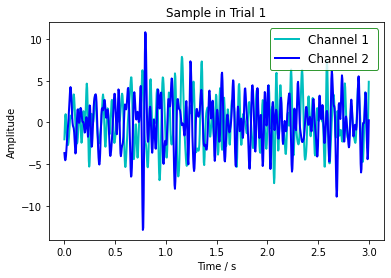

In [4]:
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

sampleRate = 250 # Sample Rate = 250Hz

# X Axis
t = np.linspace(0, data_X.shape[2] / sampleRate, data_X.shape[2])

# Sample Line
L1 = data_X[0, 0, :]
L2 = data_X[1, 0, :]

# Plot
plt.style.use('seaborn-colorblind')
plt.title("Sample in Trial 1")
plt.xlabel('Time / s')
plt.ylabel('Amplitude')

plt.plot(t, L1, 'c-', linewidth= 2, label='Channel 1 ')
plt.plot(t, L2, 'b-', linewidth = 2, label='Channel 2')

plt.legend(loc='upper right',fontsize='large',frameon=True,edgecolor='green')

## 3. CNN Models
Classify datasets with CNN models

### 3.1 1D-LeNet Model

#### 3.1.1 Build 1D-LeNet Model

<img src="https://www.researchgate.net/publication/344128059/figure/fig1/AS:1021719754072066@1620608380536/The-architecture-of-1D-LeNet-5.png" width="20%">

In [5]:
## CNN Model
# LeNet Using pytorch

import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(13, 3, 25), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.AvgPool1d(2), # kernel_size, stride
            nn.Conv1d(3, 1, 25),
            nn.Sigmoid(),
            nn.AvgPool1d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(169, 120),
            nn.Sigmoid(),
            # Add a Dropout Layer
            nn.Dropout(p=0.5),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 2)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature)
        return output


#### 3.1.2 Use Torch Summary to Print the Model
Pytorch Summary: https://github.com/sksq96/pytorch-summary

In [6]:
device = torch.device("cpu")
model = LeNet().to(device)
summary(model, (13, 750) , device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 3, 726]             978
           Sigmoid-2               [-1, 3, 726]               0
         AvgPool1d-3               [-1, 3, 363]               0
            Conv1d-4               [-1, 1, 339]              76
           Sigmoid-5               [-1, 1, 339]               0
         AvgPool1d-6               [-1, 1, 169]               0
            Linear-7               [-1, 1, 120]          20,400
           Sigmoid-8               [-1, 1, 120]               0
           Dropout-9               [-1, 1, 120]               0
           Linear-10                [-1, 1, 84]          10,164
          Sigmoid-11                [-1, 1, 84]               0
           Linear-12                 [-1, 1, 2]             170
Total params: 31,788
Trainable params: 31,788
Non-trainable params: 0
---------------------------------

#### 3.1.3 定义训练和模型评估函数

In [7]:
import time
from sklearn.model_selection import train_test_split

# Define a list to store the results of training process
losslist=[]
train_acc_list = []
test_acc_list = []

# Model Training
def train(net, data_x, data_y, optimizer, device, num_epochs):
    net = net.to(device)
    print("======= Training on", device, "=======")
    loss = torch.nn.MSELoss()
    loss=torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        # split test set and train set
        train_data, test_data, train_label, test_label = \
            train_test_split(data_X, data_y, test_size=0.3, random_state = 42)

        train_l_sum, train_acc_sum, n, batch_count, start = \
            0.0, 0.0, 0, 0, time.time()

        for X, y in zip(train_data,train_label):
            X = torch.Tensor(X)
            y = torch.LongTensor(y)
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_data, test_label, net)
        print('Epoch: %d, Loss: %.4f, Train acc: %.3f, Test acc: %.3f, Time: %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        losslist.append(train_l_sum / batch_count)
        train_acc_list.append(train_acc_sum / n)
        test_acc_list.append(test_acc)

# Model Evauation
def evaluate_accuracy(data_iter, label_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # If no device is specified, use net's device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in zip(data_iter,label_iter):
            X = torch.Tensor(X)
            y = torch.Tensor(y)
            net.eval() # evaluation mode, which turns off dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # Change back to training mode
            n += y.shape[0]
    return acc_sum / n

#### 3.1.4 Initialize and Train the 1D-LeNet Model

======= Training on cpu =======
Epoch: 1, Loss: 0.7174, Train acc: 0.487, Test acc: 0.438, Time: 1.9 sec
Epoch: 2, Loss: 0.7113, Train acc: 0.473, Test acc: 0.438, Time: 1.9 sec
Epoch: 3, Loss: 0.7047, Train acc: 0.491, Test acc: 0.438, Time: 2.0 sec
Epoch: 4, Loss: 0.7013, Train acc: 0.473, Test acc: 0.438, Time: 2.2 sec
Epoch: 5, Loss: 0.6915, Train acc: 0.529, Test acc: 0.438, Time: 1.8 sec
Epoch: 6, Loss: 0.6932, Train acc: 0.527, Test acc: 0.438, Time: 1.7 sec
Epoch: 7, Loss: 0.6837, Train acc: 0.555, Test acc: 0.454, Time: 1.8 sec
Epoch: 8, Loss: 0.6809, Train acc: 0.555, Test acc: 0.454, Time: 1.6 sec
Epoch: 9, Loss: 0.6628, Train acc: 0.598, Test acc: 0.483, Time: 1.6 sec
Epoch: 10, Loss: 0.6563, Train acc: 0.618, Test acc: 0.483, Time: 1.5 sec
Epoch: 11, Loss: 0.6456, Train acc: 0.611, Test acc: 0.500, Time: 1.5 sec
Epoch: 12, Loss: 0.6299, Train acc: 0.623, Test acc: 0.492, Time: 1.9 sec
Epoch: 13, Loss: 0.6182, Train acc: 0.643, Test acc: 0.512, Time: 2.1 sec
Epoch: 14, Loss

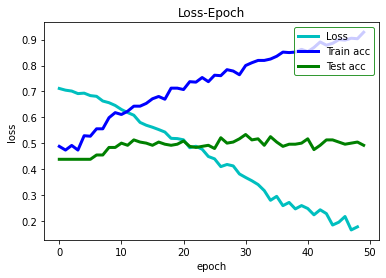

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

input_shape = data_X.shape[1], data_X.shape[2] # (13, 750)
lable_shape = data_y.shape # (800, 1)

# Build Model
net = LeNet()
lr = 0.001
num_epochs = 50
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train(net, data_X, data_y, optimizer, device, num_epochs)

# Draw Loss-Epoch Diagram
plt.style.use('seaborn-colorblind')
plt.title('Loss-Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(losslist[1:], 'c-', linewidth= 3, label='Loss')
plt.plot(train_acc_list, 'b-', linewidth = 3, label='Train acc')
plt.plot(test_acc_list, 'g-', linewidth = 3, label='Test acc')

plt.legend(loc='upper right',fontsize='medium',frameon=True,edgecolor='green')
plt.show()
plt.close()

### 3.2 EEG-Inception Neural Network
https://doi.org/10.1109/TNSRE.2020.3048106

#### 3.2.1 A Modified EEG-Inception Neural Network Model

In [9]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Activation, Input, Flatten
from keras.layers import Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, DepthwiseConv1D
from keras.layers import Dense
from keras.layers import Concatenate

def EEGInception(data_num = 750,
                 channel_num = 13,
                 sample_rate = 250,
                 filters_per_branch = 13,
                 dropout_rate = 0.25,
                 activation = 'ReLU',
                 learning_rate = 0.001
                 ):

    # The extracted features from the EEG signal are based on
    # [0.1s, 0.3s, 0.5s, 0.7s, 0.9s]
    # scales_time = [0, 100, 300, 500, 700, 900]
    kernel_size = [0, 25, 50, 75]
    # for i in range(1, 5):
    #     kernel_size[i] = scales_time[i] * sample_rate / 1000
    # kernel_size[0] = 0
    # print('Kernel Size List:', kernel_size) # [0, 25, 50, 75]

    # the max-pooling is applied to select
    # the maximum feature from the input data with a kernel size of
    # twenty-five (0.1 seconds)
    # pool_size = int(100 * sample_rate / 1000) # 0.1s
    # print('Pool Size:', pool_size) # 25

    # ================================ INPUT Layer ================================= #
    # Input Data
    input_layer = Input(shape = (data_num , channel_num))

    # ========================== BLOCK 1: INCEPTION ========================== #

    # Convolution Layer [1] with kernel size [25]
    output_Conv1 = Conv1D(filters = filters_per_branch,
                          kernel_size = kernel_size[1],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(input_layer)

    # Convolution Layer [2] with kernel size [50]
    output_Conv2 = Conv1D(filters = filters_per_branch,
                          kernel_size = kernel_size[2],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(input_layer)

    # Convolution Layer [3] with kernel size [75]
    output_Conv3 = Conv1D(filters = filters_per_branch,
                          kernel_size = kernel_size[3],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(input_layer)


    # Concanetate 3 Convolution Layers and Input Layer
    output_Concanetate = Concatenate(axis = -1)([output_Conv1, output_Conv2])
    output_Concanetate = Concatenate(axis = -1)([output_Concanetate, output_Conv3])
    output_Concanetate = Concatenate(axis = -1)([output_Concanetate, input_layer])

    output_BN = BatchNormalization()(output_Concanetate)
    output_Activation = Activation(activation)(output_BN)
    data_output1 = output_Activation

    # ========================== BLOCK 2: INCEPTION ========================== #


    # Convolution Layer [1] with kernel size [25]
    output1_Conv1 = Conv1D(filters = filters_per_branch * 4,
                          kernel_size = 25,
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(data_output1)


    # Convolution Layer [2] with kernel size [50]
    output1_Conv2 = Conv1D(filters = filters_per_branch * 4,
                          kernel_size = kernel_size[2],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(data_output1)

    # Convolution Layer [3] with kernel size [75]
    output1_Conv3 = Conv1D(filters = filters_per_branch * 4,
                          kernel_size = kernel_size[3],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(data_output1)

    # Concanetate 3 Convolution Layers and Output Layer in Upper Block
    output1_Concanetate = Concatenate(axis = -1)([output1_Conv1, output1_Conv2])
    output1_Concanetate = Concatenate(axis = -1)([output1_Concanetate, output1_Conv3])
    output1_Concanetate = Concatenate(axis = -1)([output1_Concanetate, data_output1])

    output1_BN = BatchNormalization()(output1_Concanetate)
    output1_Activation = Activation(activation)(output1_BN)
    data_output2 = Dropout(dropout_rate)(output1_Activation)


    # ============================ BLOCK 3: OUTPUT =========================== #

    # Output layer
    output_layer = Flatten()(data_output2)
    output_layer = Dense(1, activation='sigmoid')(output_layer)

    # ================================ MODEL ================================= #
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9,
                                      beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    return model

#### 3.2.2 Model Initialization and Print Network Structure

In [10]:
model = EEGInception()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 750, 13)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 750, 13)      4225        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 750, 13)      8450        ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 750, 26)      0           ['conv1d[0][0]',                 
                                                                  'conv1d_1[0][0]']           

#### 3.2.3 Model Training and Evaluation

========== Train and Evaluate ==========
Epoch 1/50
45/45 [==============================] - 9s 31ms/step - loss: 7.5733 - accuracy: 0.5335 - val_loss: 9.7869 - val_accuracy: 0.5446
Epoch 2/50
45/45 [==============================] - 1s 17ms/step - loss: 3.5111 - accuracy: 0.6585 - val_loss: 4.2898 - val_accuracy: 0.4821
Epoch 3/50
45/45 [==============================] - 1s 16ms/step - loss: 1.8293 - accuracy: 0.7857 - val_loss: 6.5276 - val_accuracy: 0.4375
Epoch 4/50
45/45 [==============================] - 1s 16ms/step - loss: 0.6503 - accuracy: 0.8728 - val_loss: 4.5313 - val_accuracy: 0.5357
Epoch 5/50
45/45 [==============================] - 1s 16ms/step - loss: 0.5466 - accuracy: 0.8862 - val_loss: 4.9252 - val_accuracy: 0.4821
Epoch 6/50
45/45 [==============================] - 1s 16ms/step - loss: 0.1895 - accuracy: 0.9531 - val_loss: 5.2115 - val_accuracy: 0.4821
Epoch 7/50
45/45 [==============================] - 1s 16ms/step - loss: 0.1634 - accuracy: 0.9665 - val_loss: 4.

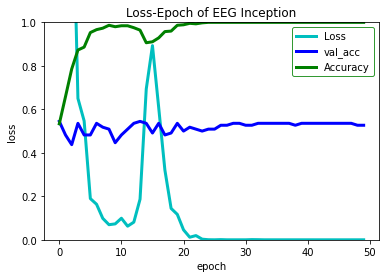

In [11]:
from keras.callbacks import ModelCheckpoint

# Reshape data_X to fit Keras model [batch, data_point, channel]
data_XT = data_X.transpose((0, 2, 1))
input_shape = data_XT.shape[0], data_XT.shape[1], data_XT.shape[2] # (800, 750, 13)
lable_shape = data_y.shape # (800, 1)

# print('Input Shape:', input_shape)
# print('Lable Shape:', lable_shape)

# Split test set and train set
train_data, test_data, train_label, test_label = \
    train_test_split(data_XT, data_y, test_size=0.3, random_state = 42)

# print('Train X Shape:', train_data.shape) # (640, 750, 13)
# print('Train y Shape:', train_label.shape) # (640, 1)


# Model Traing
model = EEGInception()

# Using checkpoint to save the best model
# checkpoint
# filepath="C:/Users/1/Desktop/CNN_EEG/models/EEG_Inception_weights-{epoch:02d}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

print("========== Train and Evaluate ==========")
history = model.fit(
    train_data,
    train_label,
    batch_size = 10,
    epochs = 50,
    validation_split=0.2,
    # shuffle=True
    # callbacks=callbacks_list
)

# Record Training Process
history.history

# Evaluate the model on the test data using `evaluate`
print("========== Evaluate on test data ==========")
results = model.evaluate(test_data, test_label, batch_size = 8)
print("test loss, test acc:", results)


# 画损失函数图
import matplotlib.pyplot as plt

plt.figure()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.style.use('seaborn-colorblind')
plt.title('Loss-Epoch of EEG Inception')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim((0, 1))

plt.plot(loss, 'c-', linewidth= 3, label='Loss')
plt.plot(val_acc, 'b-', linewidth = 3, label='val_acc')
plt.plot(acc, 'g-', linewidth = 3, label='Accuracy')

plt.legend(loc='upper right',fontsize='medium',frameon=True, edgecolor='green')
plt.show()
plt.close()

#### 3.2.4 Save the Best Model

In [12]:
# import tensorflow as tf
#
# # Save Model
# print("=========== Saving Model... ===========")
# model.load_weights("C:/Users/1/Desktop/CNN_EEG/EEG_Inception_weights-45(0.632).hdf5")
# save_filename = "C:/Users/1/Desktop/CNN_EEG"
# tf.keras.models.save_model(model, save_filename)
# print("=========== Best Model has Saved! ===========")

## 4. Make Predictions on the Test Dataset

### 4.1 Read in Test Dataset

In [13]:
# Read in Test Data S5~S8
import numpy as np

datafile5 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\test\S5.npz"
datafile6 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\test\S6.npz"
datafile7 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\test\S7.npz"
datafile8 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\test\S8.npz"

dataSet5 = np.load(datafile5)
dataSet6 = np.load(datafile6)
dataSet7 = np.load(datafile7)
dataSet8 = np.load(datafile8)

### 4.2 Load Model and Predict

In [14]:
import tensorflow as tf

# Load Model
save_filename = "C:/Users/1/Desktop/CNN_EEG"

model = tf.keras.models.load_model(save_filename)

# Split X from Dataset
dataSet5_X = dataSet5['X']
dataSet6_X = dataSet5['X']
dataSet7_X = dataSet5['X']
dataSet8_X = dataSet5['X']

# Predict Lable using model
print('================== Predicting... ==================')

y5_predict = model.predict(dataSet5_X.transpose((0, 2, 1)))
y6_predict = model.predict(dataSet6_X.transpose((0, 2, 1)))
y7_predict = model.predict(dataSet7_X.transpose((0, 2, 1)))
y8_predict = model.predict(dataSet8_X.transpose((0, 2, 1)))

print('=============== Finish Prediction! ===============')

================== Predicting... ==================
7/7 [==============================] - 0s 4ms/step
=============== Finish Prediction! ===============


In [15]:
# Transfer Probability to Classes
def prob2class(y_predict):
    y_class = []
    for i in range(0, 200):
        if abs(1 - y5_predict[i]) > abs(y5_predict[i]):
            y_class.append(0)
        else:
            y_class.append(1)
    return y_class

In [16]:
y5_class = prob2class(y5_predict)
y6_class = prob2class(y6_predict)
y7_class = prob2class(y7_predict)
y8_class = prob2class(y8_predict)

### 4.3 Write prediction results to CSV file

In [17]:
# Write prediction results to CSV file
import pandas as pd
import numpy as np
import csv

# The key value in the dictionary is the column name in the csv
dataframe = pd.DataFrame({'S5':y5_class,
                          'S6':y6_class,
                          'S7':y7_class,
                          'S8':y8_class,})

print(dataframe)

dataframe.to_csv("C:/Users/1/Desktop/CNN_EEG/result.csv",index=False,sep=',')
print('=============== Finish Writing in File! ===============')

     S5  S6  S7  S8
0     1   1   1   1
1     0   0   0   0
2     1   1   1   1
3     1   1   1   1
4     1   1   1   1
..   ..  ..  ..  ..
195   0   0   0   0
196   1   1   1   1
197   1   1   1   1
198   1   1   1   1
199   1   1   1   1

[200 rows x 4 columns]
=============== Finish Writing in File! ===============
